# DallE-Mini Text to Image Project

This notebook will walk through the set up of dalle-mini, jax, etc. without using using cache requirements of hugging-face, weights, or bias. Thereby allowing you to run this application on any machine and generate images from given prompts under runtime support.


## Environment set up and verification



In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### GPU Set up

Import Jax

In [16]:
import jax
import jax.numpy as jnp

In Google Colab select Runtime > Change Runtime Type> GPU. Validate if GPU is loaded properly

In [17]:
jax.local_device_count()

1

In [18]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

## Install and Import all AI model components

### Install DALLE-mini

In [19]:
!pip install -q dalle-mini

### Install Jax's version of the VQGan

In [20]:
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

Import all model components

In [21]:
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

### Import Hugging Face Library - already installed on Google Colab

In [22]:
from huggingface_hub import hf_hub_url, cached_download, hf_hub_download

#### Download all DallE-mini files from hugging face.  
Files are listed at the following link:

https://huggingface.co/dalle-mini/dalle-mini/tree/main

Note: All files will be saved locally.  Note: create new folders in google colab structure under content>dalle-mini>vqgan

In [23]:
import shutil

In [24]:
dalle_mini_file_list = ['config.json', 'enwiki-words-frequency.txt', 
                         'flax_model.msgpack', 'merges.txt', 
                         'special_tokens_map.json', 'tokenizer.json', 
                         'tokenizer_config.json', 'vocab.json']

In [25]:
for file in dalle_mini_file_list:
  # downloaded to local hugging face cache folder
  downloaded_file = hf_hub_download('dalle-mini/dalle-mini', filename = file)
  target_path = '/content/dalle-mini/' + file
  # copies files from the cache folder to the local dalle-mini folder
  # removes dependency on library cache - allows us to run anywhere
  # (e.g. refernce from our API)
  shutil.copy(downloaded_file, target_path)


Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/497 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Validate files successfully downloaded and we are using local file versions (not symlinks - when loaded models, symlinks do not work)

In [26]:
!ls -lah /content/dalle-mini

total 1.7G
drwxr-xr-x 4 root root 4.0K Dec  2 02:12 .
drwxr-xr-x 1 root root 4.0K Dec  2 02:11 ..
-rw-r--r-- 1 root root 1.3K Dec  2 02:11 config.json
-rw-r--r-- 1 root root  33M Dec  2 02:11 enwiki-words-frequency.txt
-rw-r--r-- 1 root root 1.7G Dec  2 02:12 flax_model.msgpack
drwxr-xr-x 2 root root 4.0K Dec  2 02:11 .ipynb_checkpoints
-rw-r--r-- 1 root root 450K Dec  2 02:12 merges.txt
-rw-r--r-- 1 root root  239 Dec  2 02:12 special_tokens_map.json
-rw-r--r-- 1 root root  497 Dec  2 02:12 tokenizer_config.json
-rw-r--r-- 1 root root 2.1M Dec  2 02:12 tokenizer.json
-rw-r--r-- 1 root root 783K Dec  2 02:12 vocab.json
drwxr-xr-x 2 root root 4.0K Dec  2 02:11 vqgan


### Retrieve all VQGAN files from hugging face
Files are listed at the following link: 

https://huggingface.co/dalle-mini/vqgan_imagenet_f16_16384/tree/main

In [27]:
vqgan_file_list = ['config.json', 'flax_model.msgpack']

In [28]:
for file in vqgan_file_list:
  # downloaded to local hugging face cache folder
  downloaded_file = hf_hub_download('dalle-mini/vqgan_imagenet_f16_16384', filename = file)
  target_path = '/content/dalle-mini/vqgan/' + file
  # copies files from the cache folder to the local dalle-mini folder
  # removes dependency on library cache - allows us to run anywhere
  # (e.g. refernce from our API)
  shutil.copy(downloaded_file, target_path)

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/304M [00:00<?, ?B/s]

Validate files successfully downloaded and we are using local file versions

In [29]:
!ls -lah /content/dalle-mini/vqgan

total 291M
drwxr-xr-x 2 root root 4.0K Dec  2 02:12 .
drwxr-xr-x 4 root root 4.0K Dec  2 02:12 ..
-rw-r--r-- 1 root root  434 Dec  2 02:12 config.json
-rw-r--r-- 1 root root 291M Dec  2 02:12 flax_model.msgpack


## Load Models

### Load DallE-mini model

uses flax_model.msgpack and config.json files

In [30]:
DALLE_MODEL_PATH = '/content/dalle-mini'
DALLE_COMMIT_ID = None
dalle_model, dalle_params = DalleBart.from_pretrained(
    DALLE_MODEL_PATH, revision = DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False,
)
# ensure model is not initialized: _do_init

Validate DallE-mini Model

In [31]:
dalle_model

In [32]:
dalle_model.config

DalleBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "eBart"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 16385,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 2730,
  "decoder_layers": 12,
  "decoder_start_token_id": 16384,
  "do_sample": true,
  "dropout": 0.0,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 2730,
  "encoder_layers": 12,
  "encoder_vocab_size": 50264,
  "eos_token_id": 16385,
  "force_ln_scale": false,
  "gradient_checkpointing": true,
  "image_length": 256,
  "image_vocab_size": 16384,
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "ln_positions": "normformer",
  "ln_type": "layernorm",
  "max_length": 257,
  "max_text_length": 64,
  "min_length": 257,
  "model_type": "dallebart",
  "normalize_text": true,
  "pad_token_id": 16385,
  "scale_embedding": false,
  "sinkhorn_iters": 1,
  "tau_init": 0.05,
  "tie_word_embeddings": false,
  "transformers_version": "4.25.1",
  "us

In [33]:
# View model params - comment out to save space on jupyter notebook
# dalle_params

### Load VQGAN Model

In [34]:
VQGAN_MODEL_PATH = '/content/dalle-mini/vqgan'
VQGAN_COMMIT_ID = None
vqgan_model, vqgan_params = VQModel.from_pretrained(
    VQGAN_MODEL_PATH, revision = VQGAN_COMMIT_ID, dtype=jnp.float16, _do_init=False,
)

Validate VQGAN Model

In [35]:
vqgan_model.config

VQGANConfig {
  "architectures": [
    "del"
  ],
  "attn_resolutions": [
    16
  ],
  "ch": 128,
  "ch_mult": [
    1,
    1,
    2,
    2,
    4
  ],
  "double_z": false,
  "dropout": 0.0,
  "embed_dim": 256,
  "give_pre_end": false,
  "in_channels": 3,
  "n_embed": 16384,
  "num_res_blocks": 2,
  "num_resolutions": 5,
  "out_ch": 3,
  "resamp_with_conv": true,
  "resolution": 256,
  "transformers_version": "4.25.1",
  "z_channels": 256
}

In [36]:
#vqgan_params #comment out to save space on jupyter notebook

### Load DallE Bart Processor

uses downloaded files related with tokenization

In [37]:
# use the same paths as dalle-mini
DALLE_MODEL_PATH = '/content/dalle-mini'
DALLE_COMMIT_ID = None
dalle_bart_processor = DalleBartProcessor.from_pretrained(
    DALLE_MODEL_PATH, revision = DALLE_COMMIT_ID)



Validate DallE Bart Processor

In [38]:
dalle_bart_processor

## Multi-GPU Set-up

This set up is optional depending on what you have available to you. But a multi-GPU implementation is activated with replication.  Specifically, it will replicate parameters on all available devices.  

Note: If ran on google collab, only one gpu is available.

In [39]:
from flax.jax_utils import replicate
params = replicate(dalle_params)
vqgan_params = replicate(vqgan_params)

## Model Inference
### Encode text to Images

Use partial class to parallelize given functions

In [40]:
from functools import partial

Use the main DallE-mini model to generate or  encode images i.e. pass in the tokenized prompt and encode them into images.

In [41]:
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums =(3,4,5,6))
def p_generate(tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale):
  return dalle_model.generate(
      **tokenized_prompt, 
      prng_key=key,
      params = params,
      top_k = top_k,
      top_p = top_p,
      temperature = temperature,
      condition_scale= condition_scale,
  )

### Decode Images

In [42]:
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
  return vqgan_model.decode_code(indices, params=params)


### Exercise Encoder Decoder Pipeline

Create example text input prompt

In [43]:
prompt = ['vincent van gogh paintings mixed with pumpkins']
# Process prompts with bart
tokenized_prompts = dalle_bart_processor(prompt)

Distribute tokenized prompts across multiple gpu devices

In [44]:
tokenized_prompt = replicate(tokenized_prompts)
print(tokenized_prompt)

{'attention_mask': ShardedDeviceArray([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]],                   dtype=int32), 'attention_mask_uncond': ShardedDeviceArray([[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]],                   dtype=int32), 'input_ids': ShardedDeviceArray([[[    0,  9208,  1512, 20898,  4016,  5487,   208,
                      32131,     2,     1,     1,     1,     1,     1,
                          1,     1,     1,     1,     1,     1,     1,
                          1,     1,     1,     1,     1,     1,     1,
                          1, 

#### Defining Model Parameters

##### Random Key Parameter

In [45]:
import random

#create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

In [46]:
# number of predictions (images) per prompt
num_predictions = 4

##### Customize Generation Paramaters
* Resource: https://huggingface.co/blog/how-to-generate

In [47]:
gen_top_k = None
gen_top_p = None
temperature = None
#conditioning scale
cond_scale = 10.0


#### Generate Images

In [48]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

In [49]:
print(f"Prompts: {prompt}")

Prompts: ['vincent van gogh paintings mixed with pumpkins']


  0%|          | 0/4 [00:00<?, ?it/s]

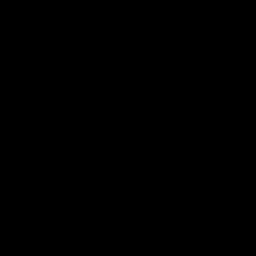

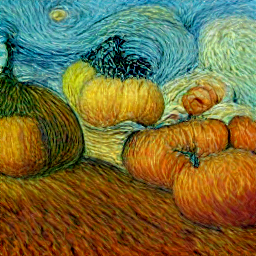

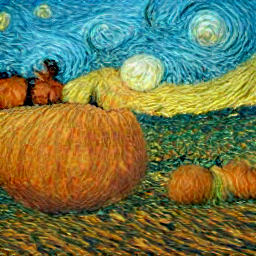

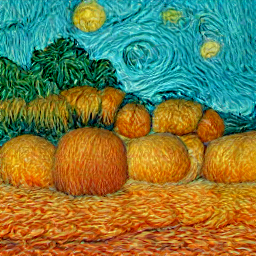

In [55]:
images = []
#device count = 1
for i in trange(max(num_predictions // jax.device_count(), 1)):
  # generate a new key
  key, subkey = jax.random.split(key)

  # Encoder
  # generate images 
  encoded_images = p_generate(
      tokenized_prompt,
      shard_prng_key(subkey),
      params,
      gen_top_k,
      gen_top_p,
      temperature,
      cond_scale,
  )

  # remove beginning of sequence
  encoded_images = encoded_images.sequences[..., 1:]

  # Decoder
  # decode images
  decoded_images = p_decode(encoded_images, vqgan_params)

  # Clip method - select top images
  decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1,256, 256,3))

  # convert images to numpy array in order to display the images
  for decoded_img in decoded_images:
    img = Image.fromarray(np.asarray(decoded_img * 255, dtype = np.uint8))
    images.append(img)
    display(img)
    print()

  

If running into errors in the above cell, ensure runtime environment is reset to use GPU (not TPU or CPU).  This may reuire rerunning all code blocks in the notebook

Check runtime environment

In [51]:
!nvidia-smi

Fri Dec  2 02:13:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   80C    P0    50W /  70W |  14300MiB / 15109MiB |     54%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Resources: https://www.youtube.com/watch?v=uVYZR6Wab7o